# Customer Lifetime Value (CLTV or CLV)



In this notebook, it is shown how to calculate the values of the customer lifetime values on the analysis date and how to predict the values of the customer lifetime values for 6 months.

In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler
from lifetimes.plotting import plot_frequency_recency_matrix


pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### Understanding the Data

In [2]:
df = pd.read_csv("flo_data_20k.csv")

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.95, 0.99, 1]).T)
    
check_df(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                              master_id order_channel last_order_channel  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App    

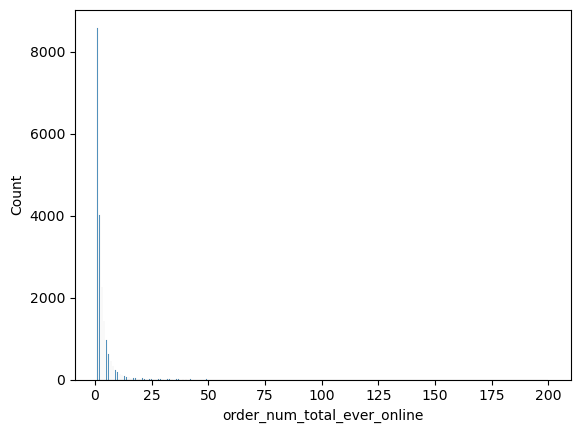

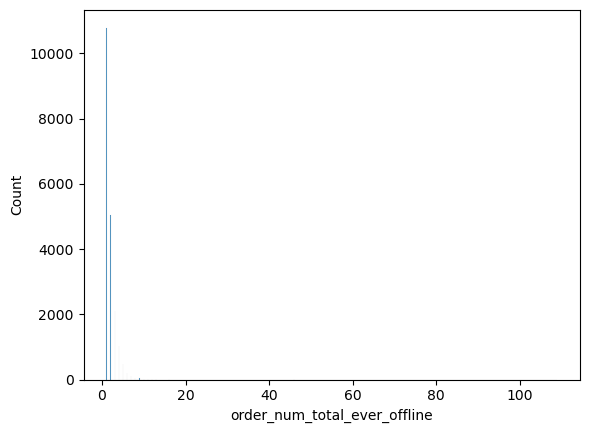

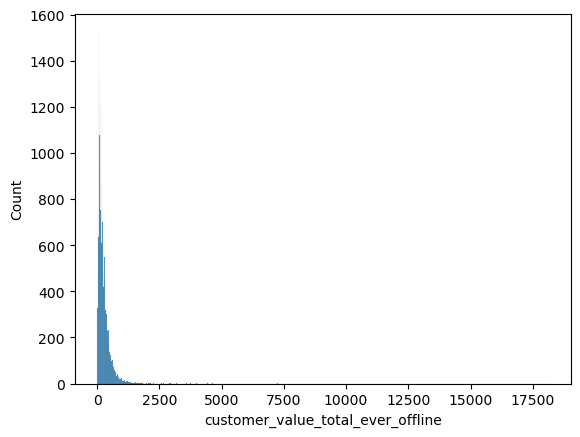

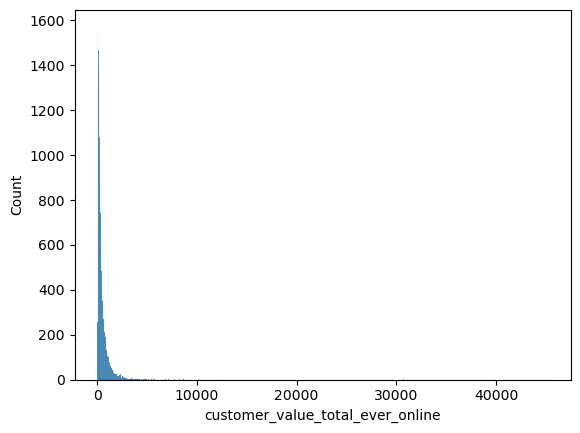

In [4]:
for col in df.columns:
    if str(df[col].dtypes) in ["int64", "float64"]:
        sns.histplot(data=df, x=col)
        plt.show(block=True)


#### Outlier Elimination

In [5]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return round(low_limit), round(up_limit)


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [6]:
for x in df.columns:
    if str(df[x].dtypes) in ["int64", "float64"]:
        print(f" for {x} threshold : {outlier_thresholds(df, x)}")

 for order_num_total_ever_online threshold : (-12, 24)
 for order_num_total_ever_offline threshold : (-4, 8)
 for customer_value_total_ever_offline threshold : (-941, 1676)
 for customer_value_total_ever_online threshold : (-2175, 3796)


In [7]:
for x in df.columns:
    if str(df[x].dtypes) in ["int64", "float64"]:
        replace_with_thresholds(df,x)

In [8]:
df.describe([0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
order_num_total_ever_online,19945.000,3.046,3.442,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2.000,2.000,3.000,4.000,7.000,10.000,20.000,24.000
order_num_total_ever_offline,19945.000,1.865,1.300,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2.000,2.000,3.000,4.000,4.000,7.000,8.000
customer_value_total_ever_offline,19945.000,249.740,233.365,10.000,19.990,39.990,59.990,89.980,110.480,140.230,179.980,220.860,281.868,365.058,519.950,694.222,1219.947,1676.000
customer_value_total_ever_online,19945.000,481.269,568.284,12.990,39.990,63.990,84.990,125.990,173.970,219.990,286.460,371.944,491.526,690.868,1082.036,1556.726,3143.810,3796.000


#### Creating new variables 

In [9]:
df["Total_Price"] = df["customer_value_total_ever_online"] + df["customer_value_total_ever_offline"]
df["Total_Order"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]

In [10]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,Total_Price,Total_Order
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],939.370,5.000
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2013.550,21.000
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",585.320,5.000
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",121.970,2.000
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],209.980,2.000


#### Changing the types of the variables

In [11]:
date_var= [col for col in df.columns if "date" in col]

for i in df[date_var]:
    df[i] = df[i].apply(pd.to_datetime)


In [12]:
df.dtypes

master_id                                    object
order_channel                                object
last_order_channel                           object
first_order_date                     datetime64[ns]
last_order_date                      datetime64[ns]
last_order_date_online               datetime64[ns]
last_order_date_offline              datetime64[ns]
order_num_total_ever_online                 float64
order_num_total_ever_offline                float64
customer_value_total_ever_offline           float64
customer_value_total_ever_online            float64
interested_in_categories_12                  object
Total_Price                                 float64
Total_Order                                 float64
dtype: object

#### Understanding the variables

In [13]:
df.groupby("order_channel").agg({"Total_Order": ["mean", "sum", "min", "max","count"],
                                 "Total_Price": ["mean", "sum", "min", "max","count"]})

Total_Order                              Total_Price  \
                     mean       sum   min    max count        mean   
order_channel                                                        
Android App         5.378 51068.000 2.000 32.000  9495     800.930   
Desktop             3.933 10756.000 2.000 29.000  2735     575.767   
Ios App             5.235 14832.000 2.000 32.000  2833     848.512   
Mobile              4.364 21304.000 2.000 27.000  4882     613.801   

                                                 
                      sum    min      max count  
order_channel                                    
Android App   7604834.780 55.980 5440.790  9495  
Desktop       1574722.290 44.980 4809.810  2735  
Ios App       2403834.270 69.980 5334.320  2833  
Mobile        2996575.470 44.980 4581.680  4882

In [14]:
#Top 10 customers with the most profits
df[["Total_Price", "master_id"]].sort_values(ascending=False, by='Total_Price').head(10)

,Total_Price,master_id
16335,5440.790,f24f6988-acd9-11e9-a2fc-000d3a38a36f
15548,5334.320,e205f2ee-acdf-11e9-a2fc-000d3a38a36f
7613,5059.760,73fd19aa-9e37-11e9-9897-000d3a38a36f
900,4999.480,a665d39e-a0d2-11e9-a2fc-000d3a38a36f
2947,4863.760,bdf7a804-b1dd-11e9-89fa-000d3a38a36f
15476,4855.910,2f1797c8-a0e6-11e9-a2fc-000d3a38a36f
5746,4839.320,6083756a-66a3-11ea-82da-000d3a38a36f
8868,4809.810,9ce6e520-89b0-11ea-a6e7-000d3a38a36f
18692,4655.930,bbc236ae-9f35-11e9-9897-000d3a38a36f
9363,4646.910,e6c4f4ba-a839-11e9-a2fc-000d3a38a36f


In [15]:
#Top 10 customers with the most orders
df[["Total_Order", "master_id"]].sort_values(ascending=False, by='Total_Order').head(10)

,Total_Order,master_id
900,32.000,a665d39e-a0d2-11e9-a2fc-000d3a38a36f
16335,32.000,f24f6988-acd9-11e9-a2fc-000d3a38a36f
5746,32.000,6083756a-66a3-11ea-82da-000d3a38a36f
6337,31.000,f7e2335e-a7c4-11e9-a2fc-000d3a38a36f
19121,30.000,a37f4760-b12a-11e9-9757-000d3a38a36f
12196,30.000,47dc9298-a6e7-11e9-a2fc-000d3a38a36f
11974,30.000,e4e1ea48-5b23-11ea-8b87-000d3a38a36f
6599,29.000,55e898a4-9e28-11e9-9897-000d3a38a36f
4079,29.000,92579b54-9f96-11e9-a2fc-000d3a38a36f
9363,29.000,e6c4f4ba-a839-11e9-a2fc-000d3a38a36f


#### Customer Lifetime Value Metrics

In [16]:
df["Date_of_analysis"] = df["last_order_date"].max() + dt.timedelta(days=2)

In [17]:
cltv = pd.DataFrame()

cltv["customer_id"] = df["master_id"]

cltv["average_order_value"] = df["Total_Price"] / df["Total_Order"]

cltv["purchase_frequency"] = df["Total_Order"] / df.shape[0]


In [18]:
cltv.head()

,customer_id,average_order_value,purchase_frequency
0,cc294636-19f0-11eb-8d74-000d3a38a36f,187.874,0.000
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,95.883,0.001
2,69b69676-1a40-11ea-941b-000d3a38a36f,117.064,0.000
3,1854e56c-491f-11eb-806e-000d3a38a36f,60.985,0.000
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,104.990,0.000


In [19]:
df[df["Total_Order"] > 1].shape[0] 

19945

In [20]:
churn_rate = 0.40 #from the case

In [21]:
# profit rate = 0.10 #from the case 
cltv['profit_margin'] = df['Total_Price'] * 0.10

In [22]:
cltv.head()

,customer_id,average_order_value,purchase_frequency,profit_margin
0,cc294636-19f0-11eb-8d74-000d3a38a36f,187.874,0.000,93.937
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,95.883,0.001,201.355
2,69b69676-1a40-11ea-941b-000d3a38a36f,117.064,0.000,58.532
3,1854e56c-491f-11eb-806e-000d3a38a36f,60.985,0.000,12.197
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,104.990,0.000,20.998


In [23]:
cltv['customer_value'] = cltv['average_order_value'] * cltv["purchase_frequency"]

### CALCULATING THE CUSTOMER LIFETIME VALUE 

In [24]:
cltv["cltv"] = (cltv["customer_value"] / churn_rate) * cltv["profit_margin"]

In [25]:
cltv.head()

,customer_id,average_order_value,purchase_frequency,profit_margin,customer_value,cltv
0,cc294636-19f0-11eb-8d74-000d3a38a36f,187.874,0.000,93.937,0.047,11.061
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,95.883,0.001,201.355,0.101,50.820
2,69b69676-1a40-11ea-941b-000d3a38a36f,117.064,0.000,58.532,0.029,4.294
3,1854e56c-491f-11eb-806e-000d3a38a36f,60.985,0.000,12.197,0.006,0.186
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,104.990,0.000,20.998,0.011,0.553


In [26]:
cltv.sort_values(by="cltv", ascending=False).head()

,customer_id,average_order_value,purchase_frequency,profit_margin,customer_value,cltv
16335,f24f6988-acd9-11e9-a2fc-000d3a38a36f,170.025,0.002,544.079,0.273,371.048
15548,e205f2ee-acdf-11e9-a2fc-000d3a38a36f,254.015,0.001,533.432,0.267,356.668
7613,73fd19aa-9e37-11e9-9897-000d3a38a36f,202.390,0.001,505.976,0.254,320.897
900,a665d39e-a0d2-11e9-a2fc-000d3a38a36f,156.234,0.002,499.948,0.251,313.297
2947,bdf7a804-b1dd-11e9-89fa-000d3a38a36f,270.209,0.001,486.376,0.244,296.517


## PREDICTION OF CUSTOMER LIFETIME VALUE

In [27]:
cltv_pred = pd.DataFrame()

cltv_pred["customer_id"] = df["master_id"]

cltv_pred["recency_cltv_weekly"] = ((df["last_order_date"] - df["first_order_date"]).astype('timedelta64[D]')) / 7 #weekly

cltv_pred["T_weekly"] = ((df["Date_of_analysis"] - df["first_order_date"]).astype('timedelta64[D]')) / 7 #weekly

cltv_pred["frequency"] = df["Total_Order"]

cltv_pred["monetary_cltv_avg"] = df["Total_Price"] / df["Total_Order"] #average

cltv_pred = cltv_pred[(cltv_pred['frequency'] > 1)]

In [28]:
cltv_pred.describe([0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
recency_cltv_weekly,19945.000,95.263,74.589,0.000,1.429,12.571,25.714,44.000,56.571,67.143,76.571,86.714,100.000,120.286,200.943,276.686,350.223,433.429
T_weekly,19945.000,114.472,74.771,0.714,11.920,29.886,48.286,68.286,78.429,85.714,93.000,104.286,116.286,138.171,220.571,296.286,372.143,437.143
frequency,19945.000,4.912,3.724,2.000,2.000,2.000,2.000,2.000,3.000,3.000,4.000,4.000,5.000,7.000,9.000,12.000,22.000,32.000
monetary_cltv_avg,19945.000,151.953,72.130,22.490,49.490,68.555,80.157,97.212,110.480,123.655,137.292,153.065,170.805,196.011,238.055,284.401,397.954,1065.800


### BG/NBD Model

In [29]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [30]:
bgf.fit(cltv_pred['frequency'],
        cltv_pred['recency_cltv_weekly'],
        cltv_pred['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 80.49, b: 0.00, r: 3.83>

In [31]:
#Estimate the expected purchases from customers within 3 months and add to CLTV DataFrame as expp_sales_3_month

cltv_pred["exp_sales_3_month"] = bgf.predict(12,  #4*3
                                           cltv_pred['frequency'],
                                           cltv_pred['recency_cltv_weekly'],
                                           cltv_pred['T_weekly'])

In [32]:
#Estimate the expected purchases from customers within 6 months and add to CLTV DataFrame as Exp_Sales_6_Month.

cltv_pred["exp_sales_6_month"] = bgf.predict(24,
                                           cltv_pred['frequency'],
                                           cltv_pred['recency_cltv_weekly'],
                                           cltv_pred['T_weekly'])

In [33]:
cltv_pred.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874,0.954,1.907
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21.000,95.883,0.976,1.951
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064,0.665,1.329
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985,0.690,1.380
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990,0.397,0.795


In [34]:
#Check out the 10 people who will make the most purchase in the 3rd month.
cltv_pred[["exp_sales_3_month","customer_id"]].sort_values(ascending=False, by="exp_sales_3_month").head(10)

,exp_sales_3_month,customer_id
8328,3.040,1902bf80-0035-11eb-8341-000d3a38a36f
15611,2.971,4a7e875e-e6ce-11ea-8f44-000d3a38a36f
19538,2.744,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f
14373,2.726,f00ad516-c4f4-11ea-98f7-000d3a38a36f
6666,2.673,53fe00d4-7b7a-11eb-960b-000d3a38a36f
7330,2.585,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f
6756,2.392,27310582-6362-11ea-a6dc-000d3a38a36f
14054,2.347,645b95bc-544e-11ea-b1db-000d3a38a36f
1364,2.176,a2c95e4e-5b09-11ea-acac-000d3a38a36f
5759,2.149,dd8f7930-615f-11ea-8dd8-000d3a38a36f


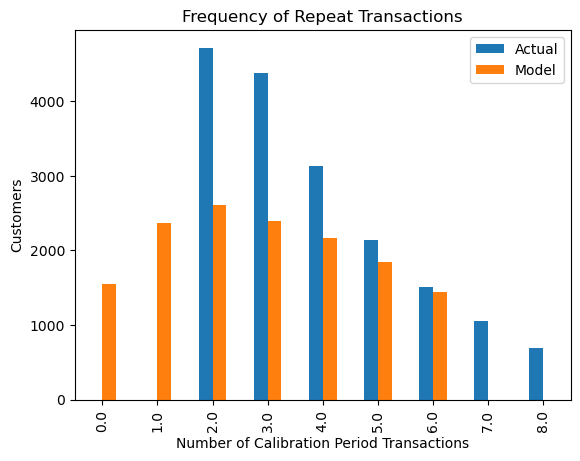

In [35]:
plot_period_transactions(bgf)  
plt.show(block=True)

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

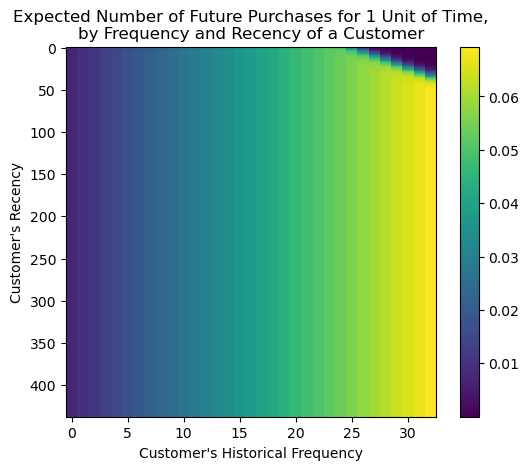

In [36]:
plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

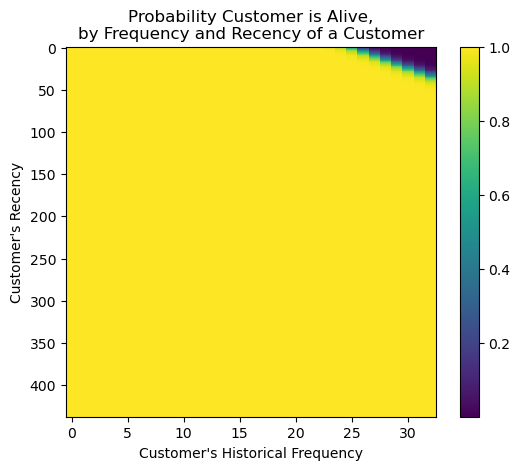

In [37]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

### Gamma Gamma Model

In [38]:
ggf = GammaGammaFitter(penalizer_coef=0.0001)

In [39]:
ggf.fit(cltv_pred['frequency'],
        cltv_pred["monetary_cltv_avg"])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 23.80, q: 4.53, v: 23.60>

In [40]:
cltv_pred["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_pred['frequency'],
                                                                             cltv_pred['monetary_cltv_avg'])

In [41]:
cltv_pred[["expected_average_profit","customer_id"]].sort_values(ascending=False, by="expected_average_profit").head(10)

,expected_average_profit,customer_id
9055,1033.339,47a642fe-975b-11eb-8c2a-000d3a38a36f
15516,942.412,9083981a-f59e-11e9-841e-000d3a38a36f
6402,814.050,851de3b4-8f0c-11eb-8cb8-000d3a38a36f
7936,812.020,ae4ce104-dbd4-11ea-8757-000d3a38a36f
16410,811.155,6fecd6c8-261a-11ea-8e1c-000d3a38a36f
9738,805.074,3a27b334-dff4-11ea-acaa-000d3a38a36f
1853,789.088,f02473b0-43c3-11eb-806e-000d3a38a36f
2291,751.239,26ac1432-1dd3-11ea-8bf2-000d3a38a36f
12828,736.390,0c24fc44-2ac8-11ea-9d27-000d3a38a36f
11179,722.666,d2e74a36-3228-11eb-860c-000d3a38a36f


### CLTV Calculation by using BG-NBD & Gamma-Gamma Models

##### 6 months prediction

In [42]:
cltv_pred["cltv"] = ggf.customer_lifetime_value(bgf,
                            cltv_pred['frequency'],
                            cltv_pred['recency_cltv_weekly'],
                            cltv_pred['T_weekly'],
                            cltv_pred["monetary_cltv_avg"],
                            time=6,  #month 
                            freq="W", #week 
                            )

In [43]:
#Top 10 CLTV score for 10 people
cltv_pred[["cltv","customer_id"]].sort_values(ascending=False, by="cltv").head(10)

,cltv,customer_id
9055,2305.211,47a642fe-975b-11eb-8c2a-000d3a38a36f
13880,1558.937,7137a5c0-7aad-11ea-8f20-000d3a38a36f
8868,1537.207,9ce6e520-89b0-11ea-a6e7-000d3a38a36f
6402,1328.313,851de3b4-8f0c-11eb-8cb8-000d3a38a36f
14858,1281.328,031b2954-6d28-11eb-99c4-000d3a38a36f
6717,1279.597,40b4f318-9dfb-11eb-9c47-000d3a38a36f
11694,1223.958,90f1b7f2-bbad-11ea-a0c9-000d3a38a36f
7312,1176.371,90befc98-925a-11eb-b584-000d3a38a36f
11179,1163.463,d2e74a36-3228-11eb-860c-000d3a38a36f
10876,1160.708,ae149d98-9b6a-11eb-9c47-000d3a38a36f


### Segmentation According To Customer Lifetime Value Score

In [44]:
cltv_pred["cltv_segment"] = pd.qcut(cltv_pred["cltv"], 3 , labels= ["C", "B", "A"])

In [45]:
cltv_pred.groupby("cltv_segment").agg({"recency_cltv_weekly" : 'mean',
                                     'frequency': 'mean',
                                     'monetary_cltv_avg': 'mean',
                                     'cltv': 'mean',}).sort_values(ascending=False, by='cltv_segment')

,recency_cltv_weekly,frequency,monetary_cltv_avg,cltv
cltv_segment,,,,
A,71.455,6.255,213.473,306.246
B,86.246,4.689,142.856,159.735
C,128.085,3.791,99.538,88.161


#### Analysis

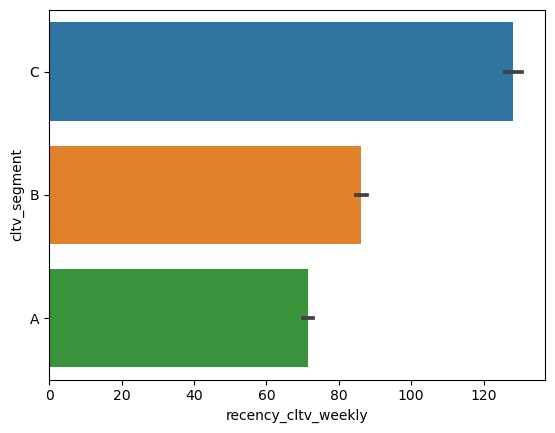

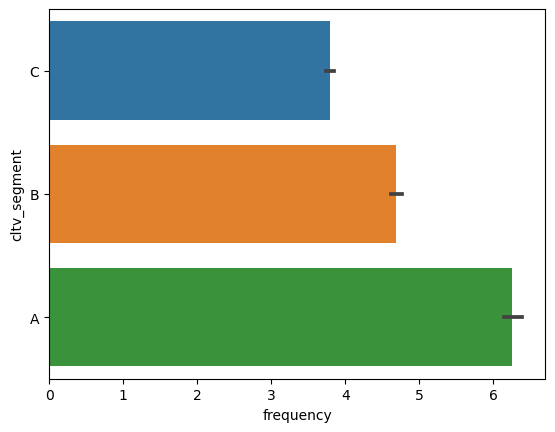

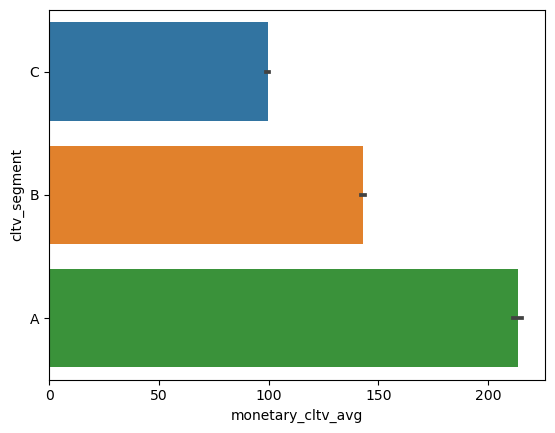

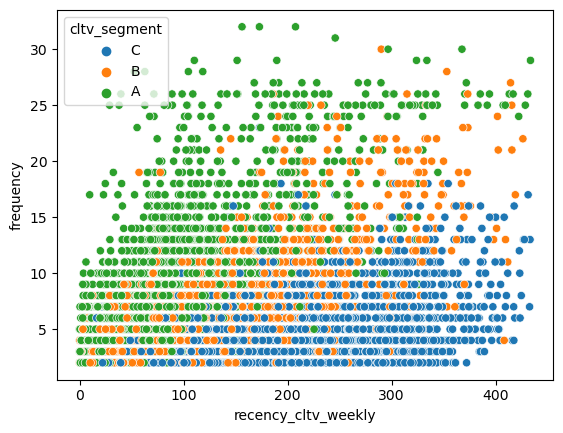

In [46]:
def visualization(df, col, y):
    sns.barplot(x=df[col], y=df[y], estimator=np.mean);
    plt.show(block=True)
    
list = ["recency_cltv_weekly", "frequency", "monetary_cltv_avg"]
for i in list:
    visualization(cltv_pred, i, "cltv_segment")

sns.scatterplot(x="recency_cltv_weekly", y="frequency", hue="cltv_segment", data=cltv_pred)
plt.show(block=True)    